In [1]:
# Cell 1: ライブラリのインポートとモデル定義
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary
from sklearn.model_selection import train_test_split

import numpy as np
import warnings
import time
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

# PyTorchの警告を無視 (開発時は非推奨ですが、Notebookでの実行をスムーズにするため)
warnings.filterwarnings("ignore")

import sys
sys.path.append("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/training/models")
from Binary_classification import Binary_classification as model

# デバイス設定
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"使用デバイス: {device}")

使用デバイス: cpu


In [2]:
temp_model = model(latent=100, 
                   input_depth=30, input_height=100, input_width=100
                  ) 
dummy_input = torch.randn(1, 1, 30, 100, 100) 

# 特徴抽出層まで実行
output_features = temp_model.features(dummy_input)

# 結果のサイズを確認
print(output_features.size())

TypeError: Binary_classification.__init__() got an unexpected keyword argument 'input_depth'

In [ ]:
class DataSet:
    def __init__(self, data, label):
        self.label = label
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [ ]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""

    def __init__(self, path, patience=10, verbose=False, delta=0, trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement.
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score <= self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            # self.flog.write(f'EarlyStopping counter: {self.counter} out of {self.patience}\n')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    
    def save_checkpoint(self, val_loss, model):
        """Saves model when validation loss decrease."""
        if self.verbose:
            self.trace_func(
                f"Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ..."
            )
            # self.flog.write(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...\n')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [ ]:
training_bubble = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/data/processed_data/split_area/training_data/training_bubble.npy")
training_data = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/data/processed_data/split_area/training_data/training_data.npy")

# バブルのラベルは1、非バブルのラベルは0
training_bubble_label = [1] * len(training_bubble)
training_data_label = [0] * len(training_data)

validation_bubble = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/data/processed_data/split_area/validation_data/cheating_data/validation_cheating_bubble.npy")
validation_data = np.load("/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/data/processed_data/split_area/validation_data/cheating_data/validation_cheating_data.npy")

# バブルのラベルは1、非バブルのラベルは0
validation_bubble_label = [1] * len(validation_bubble)
validation_data_label = [0] * len(validation_data)

In [ ]:
print(len(training_bubble))
print(len(training_data))
print(len(validation_bubble))
print(len(validation_data))

In [ ]:
# bubble_data = bubble_data[bubble_cut_val:]
# removal_data = removal_data[removal_cut_val:]
# print(len(bubble_data))
# print(len(removal_data))

In [ ]:
# bubble_label = [1] * len(bubble_data)
# removal_label = [0] * len(removal_data)

# print(len(bubble_label))
# print(len(removal_label))

In [ ]:
data = np.concatenate((training_bubble, training_data, validation_bubble, validation_data))
label = np.concatenate((training_bubble_label, training_data_label, validation_bubble_label, validation_data_label))

# val_data = np.concatenate((validation_bubble, validation_data))
# val_label = np.concatenate((validation_bubble_label, validation_data_label))

In [ ]:
data = torch.from_numpy(data).float()
train_data, val_data, train_labels, val_labels = train_test_split(
    data, label, test_size=0.2, random_state=42, stratify=label
)
# val_data, test_data, val_labels, test_labels = train_test_split(
#     val_data, val_labels, test_size=0.25, random_state=42, stratify=val_labels
# )

# train_data = augment_data(train_data, augment_horizontal, augment_vertical, augment_velocity_axis)
# train_labels     = [0] * len(train_data)

train_dataset    = DataSet(train_data, train_labels)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataset      = DataSet(val_data, val_labels)
val_dataloader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
dataloader_dic   = {"train": train_dataloader, "val": val_dataloader}

# train_dataset = DataSet(train_data, train_labels)
# train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_dataset = DataSet(val_data, val_labels)
# val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)
# dataloader_dic = {"train": train_dataloader, "val": val_dataloader}

In [ ]:
print(len(train_dataset))
print(len(val_data))
# print(len(test_data))

In [ ]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0.0)

In [ ]:
model = model(latent=100, 
              # input_depth=30, input_height=100, input_width=100
             )
model.apply(weights_init)
model.to(device)

In [14]:
optimizer = optim.AdamW(
        model.parameters(), lr=1e-4, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.001, amsgrad=False
    )
criterion = nn.BCELoss()

In [15]:
early_stopping = EarlyStopping(patience=20, verbose=True, path="/home/cygnus/fujimoto/Cygnus-X_Molecular_Cloud_Analysis/Binary_classification/training/save_dir/binary_cheting_model.pth")

In [16]:
train_loss_list = []

val_loss_list = []
val_accuracy_list = []
val_recall_list = []
val_precision_list = []

best_val_loss = float('inf')
start = time.time()
num_epochs = 1000


for epoch in range(num_epochs):
    train_loss_num = 0
    val_loss_num = 0

    # 精度計算のためのカウンター
    val_correct_preds = 0
    val_total_samples = 0
    val_true_positives = 0
    val_actual_positives = 0 # (TP + FN)
    val_predicted_positives = 0

    for phase in ["train", "val"]:
        dataloader = dataloader_dic[phase]
        if phase == "train":
            model.train()  # モデルを訓練モードに
        else:
            model.eval()

        for images, labels in tqdm(dataloader):
            images = images.view(-1, 1, 30, 100, 100)
            labels = labels.to(device).float().unsqueeze(1)
            # print(labels)
            optimizer.zero_grad()
            with torch.set_grad_enabled(phase == "train"):

                # モデルの出力を計算する
                output, latent = model(images.clone().float().to(device))
                # print(output)
                # print(labels)
                # 損失を計算する
                loss = criterion(output.to("cpu"), labels.to("cpu"))
                weighted_loss = torch.mean(loss)

                if phase == "val":
                    # Sigmoid出力 (output) を使用し、0.5を閾値として予測
                    # outputは [B, 1]、labels_deviceは [B, 1]
                    predicted = (output > 0.5).float()
                    
                    # 1. 精度 (Accuracy) の計算
                    val_correct_preds += (predicted == labels).sum().item()
                    val_total_samples += labels.size(0)
                    
                    # 2. Recallの計算
                        # a. True Positives (TP): predicted=1 かつ actual=1
                    val_true_positives += ((predicted == 1) & (labels == 1)).sum().item()
                    
                        # b. Actual Positives (TP + FN): actual=1 (正解ラベルが1の総数)
                    val_actual_positives += (labels == 1).sum().item()

                    # 3. Precision用 【追加】 (分母: 予測した正例数)
                    val_predicted_positives += (predicted == 1).sum().item()
                
                # パラメータの更新
                if phase == "train":
                    weighted_loss.backward()
                    optimizer.step()
                    train_loss_num += weighted_loss.item()
                else:
                    val_loss_num += weighted_loss.item()
                    
        # エポック終了後の検証精度の計算
        val_accuracy = val_correct_preds / val_total_samples if val_total_samples > 0 else 0.0
        
        # ⭐ 検証再現率 (Recall) の計算 ⭐
        val_recall = val_true_positives / val_actual_positives if val_actual_positives > 0 else 0.0

        # Precision = TP / (TP + FP) = TP / Predicted Positives 【追加】
        val_precision = val_true_positives / val_predicted_positives if val_predicted_positives > 0 else 0.0
        
        if phase == "train":
            train_loss_list.append(train_loss_num)
        else:
            val_loss_list.append(val_loss_num)
            val_accuracy_list.append(val_accuracy)
            val_recall_list.append(val_recall)
            val_precision_list.append(val_precision)
            
    # wandb.log({"train loss": train_loss_num, "validation loss": val_loss_num, "epoch":  epoch})
    # if val_loss_num < best_val_loss:
    #     best_val_loss = val_loss_num
        # wandb.log({"best validation loss": best_val_loss, "epoch":  epoch})
    
    # print("Epoch [{}/{}], Loss: {:.4f}".format(epoch + 1, num_epochs, val_loss_num))
    print("Epoch [{}/{}], Val Loss: {:.4f}, Val Accuracy: {:.4f}, Val Recall: {:.4f}, Val Precision: {:.4f}".format(
        epoch + 1, num_epochs, val_loss_num, val_accuracy, val_recall ,val_precision
    ))
    
    early_stopping(val_loss_num, model)
    if early_stopping.early_stop:
        print("Early_Stopping")
        break
    print("")
    
#train_loss_path = args.savedir_path + "/loss_log" + f"/train_loss_{args.wandb_name}.npy"
#val_loss_path = args.savedir_path + "/loss_log" + f"/val_loss_{args.wandb_name}.npy"

#np.save(train_loss_path, train_loss_list)
#np.save(val_loss_path, val_loss_list)

print((time.time() - start) / 60)

  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [1/1000], Val Loss: 9.1384, Val Accuracy: 0.9474, Val Recall: 0.0000, Val Precision: 0.0000
Validation loss decreased (inf --> 9.138404).  Saving model ...



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [2/1000], Val Loss: 6.2131, Val Accuracy: 0.9474, Val Recall: 0.0000, Val Precision: 0.0000
Validation loss decreased (9.138404 --> 6.213074).  Saving model ...



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [3/1000], Val Loss: 10.4761, Val Accuracy: 0.9496, Val Recall: 0.0408, Val Precision: 1.0000
EarlyStopping counter: 1 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [4/1000], Val Loss: 2.0470, Val Accuracy: 0.9903, Val Recall: 0.8571, Val Precision: 0.9545
Validation loss decreased (6.213074 --> 2.046957).  Saving model ...



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [5/1000], Val Loss: 3.2159, Val Accuracy: 0.9796, Val Recall: 0.6122, Val Precision: 1.0000
EarlyStopping counter: 1 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [6/1000], Val Loss: 2.3529, Val Accuracy: 0.9818, Val Recall: 0.6531, Val Precision: 1.0000
EarlyStopping counter: 2 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [7/1000], Val Loss: 2.2848, Val Accuracy: 0.9796, Val Recall: 0.7959, Val Precision: 0.8125
EarlyStopping counter: 3 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [8/1000], Val Loss: 23.8789, Val Accuracy: 0.8498, Val Recall: 1.0000, Val Precision: 0.2593
EarlyStopping counter: 4 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [9/1000], Val Loss: 0.7690, Val Accuracy: 0.9946, Val Recall: 0.9796, Val Precision: 0.9231
Validation loss decreased (2.046957 --> 0.768984).  Saving model ...



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [10/1000], Val Loss: 3.7479, Val Accuracy: 0.9742, Val Recall: 1.0000, Val Precision: 0.6712
EarlyStopping counter: 1 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [11/1000], Val Loss: 1.0017, Val Accuracy: 0.9946, Val Recall: 1.0000, Val Precision: 0.9074
EarlyStopping counter: 2 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [12/1000], Val Loss: 4.6000, Val Accuracy: 0.9689, Val Recall: 1.0000, Val Precision: 0.6282
EarlyStopping counter: 3 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [13/1000], Val Loss: 2.7764, Val Accuracy: 0.9818, Val Recall: 0.9796, Val Precision: 0.7500
EarlyStopping counter: 4 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [14/1000], Val Loss: 0.6197, Val Accuracy: 0.9957, Val Recall: 0.9184, Val Precision: 1.0000
Validation loss decreased (0.768984 --> 0.619726).  Saving model ...



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [15/1000], Val Loss: 0.3975, Val Accuracy: 0.9979, Val Recall: 0.9592, Val Precision: 1.0000
Validation loss decreased (0.619726 --> 0.397479).  Saving model ...



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [16/1000], Val Loss: 0.1668, Val Accuracy: 0.9989, Val Recall: 0.9796, Val Precision: 1.0000
Validation loss decreased (0.397479 --> 0.166754).  Saving model ...



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [17/1000], Val Loss: 0.1280, Val Accuracy: 0.9989, Val Recall: 0.9796, Val Precision: 1.0000
Validation loss decreased (0.166754 --> 0.127985).  Saving model ...



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [18/1000], Val Loss: 0.5166, Val Accuracy: 0.9979, Val Recall: 1.0000, Val Precision: 0.9608
EarlyStopping counter: 1 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [19/1000], Val Loss: 0.6174, Val Accuracy: 0.9946, Val Recall: 1.0000, Val Precision: 0.9074
EarlyStopping counter: 2 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [20/1000], Val Loss: 0.1181, Val Accuracy: 0.9989, Val Recall: 0.9796, Val Precision: 1.0000
Validation loss decreased (0.127985 --> 0.118120).  Saving model ...



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [21/1000], Val Loss: 1.1065, Val Accuracy: 0.9925, Val Recall: 0.8571, Val Precision: 1.0000
EarlyStopping counter: 1 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [22/1000], Val Loss: 0.1797, Val Accuracy: 0.9989, Val Recall: 0.9796, Val Precision: 1.0000
EarlyStopping counter: 2 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [23/1000], Val Loss: 0.0317, Val Accuracy: 1.0000, Val Recall: 1.0000, Val Precision: 1.0000
Validation loss decreased (0.118120 --> 0.031746).  Saving model ...



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [24/1000], Val Loss: 0.0641, Val Accuracy: 1.0000, Val Recall: 1.0000, Val Precision: 1.0000
EarlyStopping counter: 1 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [25/1000], Val Loss: 0.0844, Val Accuracy: 1.0000, Val Recall: 1.0000, Val Precision: 1.0000
EarlyStopping counter: 2 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [26/1000], Val Loss: 0.0757, Val Accuracy: 0.9989, Val Recall: 0.9796, Val Precision: 1.0000
EarlyStopping counter: 3 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [27/1000], Val Loss: 0.0672, Val Accuracy: 0.9989, Val Recall: 0.9796, Val Precision: 1.0000
EarlyStopping counter: 4 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [28/1000], Val Loss: 0.0487, Val Accuracy: 1.0000, Val Recall: 1.0000, Val Precision: 1.0000
EarlyStopping counter: 5 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [29/1000], Val Loss: 0.0671, Val Accuracy: 0.9989, Val Recall: 0.9796, Val Precision: 1.0000
EarlyStopping counter: 6 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [30/1000], Val Loss: 0.0662, Val Accuracy: 0.9989, Val Recall: 0.9796, Val Precision: 1.0000
EarlyStopping counter: 7 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [31/1000], Val Loss: 0.6844, Val Accuracy: 0.9979, Val Recall: 1.0000, Val Precision: 0.9608
EarlyStopping counter: 8 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [32/1000], Val Loss: 0.7891, Val Accuracy: 0.9968, Val Recall: 0.9796, Val Precision: 0.9600
EarlyStopping counter: 9 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [33/1000], Val Loss: 0.5669, Val Accuracy: 0.9946, Val Recall: 0.8980, Val Precision: 1.0000
EarlyStopping counter: 10 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [34/1000], Val Loss: 0.2088, Val Accuracy: 0.9989, Val Recall: 0.9796, Val Precision: 1.0000
EarlyStopping counter: 11 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [35/1000], Val Loss: 0.0797, Val Accuracy: 1.0000, Val Recall: 1.0000, Val Precision: 1.0000
EarlyStopping counter: 12 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [36/1000], Val Loss: 0.1975, Val Accuracy: 0.9989, Val Recall: 0.9796, Val Precision: 1.0000
EarlyStopping counter: 13 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [37/1000], Val Loss: 0.1018, Val Accuracy: 1.0000, Val Recall: 1.0000, Val Precision: 1.0000
EarlyStopping counter: 14 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [38/1000], Val Loss: 0.0457, Val Accuracy: 1.0000, Val Recall: 1.0000, Val Precision: 1.0000
EarlyStopping counter: 15 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [39/1000], Val Loss: 0.0501, Val Accuracy: 1.0000, Val Recall: 1.0000, Val Precision: 1.0000
EarlyStopping counter: 16 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [40/1000], Val Loss: 0.0630, Val Accuracy: 0.9989, Val Recall: 0.9796, Val Precision: 1.0000
EarlyStopping counter: 17 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [41/1000], Val Loss: 0.0331, Val Accuracy: 1.0000, Val Recall: 1.0000, Val Precision: 1.0000
EarlyStopping counter: 18 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [42/1000], Val Loss: 0.0438, Val Accuracy: 1.0000, Val Recall: 1.0000, Val Precision: 1.0000
EarlyStopping counter: 19 out of 20



  0%|          | 0/233 [00:00<?, ?it/s]

  0%|          | 0/59 [00:00<?, ?it/s]

Epoch [43/1000], Val Loss: 0.0531, Val Accuracy: 1.0000, Val Recall: 1.0000, Val Precision: 1.0000
EarlyStopping counter: 20 out of 20
Early_Stopping
11.147921387354533


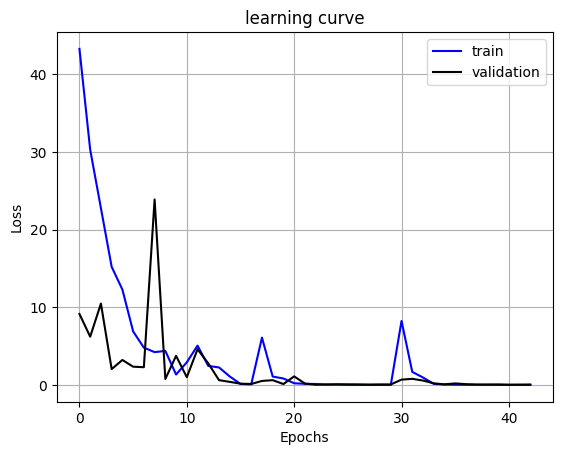

In [19]:
plt.plot(range(len(train_loss_list)), train_loss_list, "b", label="train")
plt.plot(range(len(val_loss_list)), val_loss_list, "k", label="validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("learning curve")
plt.legend()
plt.grid()
plt.savefig("Split_area_Loss.png")
plt.show()

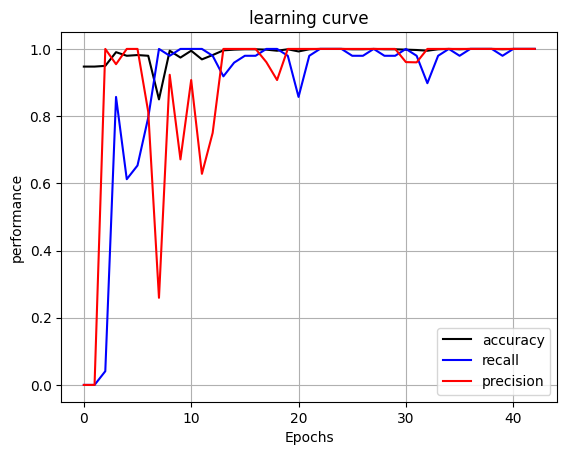

In [20]:
plt.plot(range(len(val_accuracy_list)), val_accuracy_list, "k", label="accuracy")
plt.plot(range(len(val_recall_list)), val_recall_list, "b", label="recall")
plt.plot(range(len(val_precision_list)), val_precision_list, "r", label="precision")
plt.xlabel("Epochs")
plt.ylabel("performance")
plt.title("learning curve")
plt.legend()
plt.grid()
plt.savefig("Split_area_accuracy.png")
plt.show()

In [22]:
import math
print(math.log(0.98))

-0.020202707317519466
